<a href="https://colab.research.google.com/github/ran4erep/Stable-Colab/blob/main/Stable_Diffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Если не хотите сохранять все сгенерированные изображения в Google Диск, то снимите флажок возле надписи use_gdrive и не запускайте блок кода "Подключение к Google Drive"

In [ ]:
# @title Хотите исользовать Google Drive? { run: "auto", form-width: "100%", display-mode: "form" }
use_gdrive = True # @param {type:"boolean"}


In [ ]:
# @title Подключение к Google Drive:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
# @title Установка Stable Diffusion и его зависимостей: { vertical-output: true, display-mode: "both" }
!pip install diffusers["torch"] transformers
!pip install accelerate
!pip install git+https://github.com/huggingface/diffusers

In [ ]:
# @title Подготовка Stable Diffusion: { run: "auto", vertical-output: true, form-width: "100%", display-mode: "form" }
# @markdown
# @markdown В переменной **current_checkpoint** указываем чекпоинт модель с HuggingFace,  взять её можно на [CivitAI](https://civitai.com/models). При поиске моделей, в фильтре, ставим галочку только на checkpoint.
# @markdown
# @markdown  Потом уже заходим на [HuggingFace](https://huggingface.co/models?library=diffusers) и ищем там понравившеюся модель по её названию с CivitAI. Копируем это название и вставляем в значение переменной **current_checkpoint**.
# @markdown
# @markdown  Есть [калькулятор разрешений](https://wtools.io/ru/aspect-ratio-calculator), для того чтобы подобрать цифры пропорциональные нужному соотношению сторон.

#!nvidia-smi - если раскомментировать, то будет показывать информацию о видеокарте

import torch
import os
from google.colab import files
#from diffusers import StableDiffusionPipeline
from diffusers import AutoPipelineForText2Image
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
)
from PIL import Image
import numpy as np

####################
# Список опробованных мною моделей:
# PicX_real:     GraydientPlatformAPI/picx-real
# Juggernaut:    digiplay/Juggernaut_final
# Juggernaut XL: frankjoshua/juggernautXL_version6Rundiffusion
# RealVisXL 3.0: SG161222/RealVisXL_V3.0_Turbo
####################

# @markdown Текущая модель:
current_checkpoint = "digiplay/Juggernaut_final" # @param ["digiplay/Juggernaut_final", "GraydientPlatformAPI/picx-real", "frankjoshua/juggernautXL_version6Rundiffusion", "SG161222/RealVisXL_V3.0_Turbo"] {allow-input: true}
# @markdown Текущее устройство:
current_device = "cuda" # @param ["cuda"]


# Список планировщиков
ddpm = DDPMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
ddim = DDIMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
pndm = PNDMScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
lms = LMSDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
euler = EulerDiscreteScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")
dpm = DPMSolverMultistepScheduler.from_pretrained(current_checkpoint, subfolder="scheduler")

# @markdown Текущий планировщик:
current_scheduler = euler # @param ["ddpm", "ddim", "pndm", "lms", "euler_anc", "euler", "dpm"] {type:"raw"}

# Настройка пайплайна
pipe = AutoPipelineForText2Image.from_pretrained(current_checkpoint, torch_dtype=torch.float16, variant="fp16")
#pipe = StableDiffusionPipeline.from_pretrained(current_checkpoint, torch_dtype=torch.float16)
pipe = pipe.to(current_device)
pipe.safety_checker = None # Отключение NSFW (18+)
pipe.scheduler = current_scheduler.from_config(pipe.scheduler.config) # <-- Здесь выбираем планировщик, список в переменных выше

# Создаём папку в Google Drive, если её нет
if not os.path.exists("/content/gdrive/MyDrive/SDOutput") and use_gdrive:
  os.makedirs("/content/gdrive/MyDrive/SDOutput", exist_ok=True)
  print("Создана папка для автосохранения изображений в Google Drive")

In [ ]:
# @title Настройка пайплайна: { run: "auto", form-width: "100%", display-mode: "form" }
# Здесь указываем переменные для пайплайна Stable Diffusion
# Дефолтный промпт для лучшего качества: (8k, ultra realistic, highly detailed, cinematic lighting)

# @markdown Промпт:
prompt = "skull, eerie atmosphere, 8k, ultra realistic, highly detailed, cinematic lighting" # @param {type:"string"}
# @markdown Негативный промпт:
negs = "ugly face, canvas frame, cartoon, 3d, disfigured, bad art, deformed, extra limbs, close up, b&w, wierd colors, blurry, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, out of frame, ugly, extra limbs, bad anatomy, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, mutated hands, fused fingers, too many fingers, long neck, Photoshop, video game, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, 3d render" # @param {type:"string"}
# @markdown Ширина:
width = 512 # @param {type:"number"}
# @markdown Высота:
height = 512 # @param {type:"number"}
# @markdown Шаги:
steps = 50 # @param {type:"number"}
# @markdown Шкала инструкции:
gscale = 7.5 # @param {type:"number"}
# @markdown Использовать случайный seed?
randomness = True # @param {type:"boolean"}
# @markdown Seed:
seed = 4164594511988624 # @param {type:"integer"}

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

###############
Текущая модель Stable Diffusion: digiplay/Juggernaut_final
Промпт: naked girls, eerie atmosphere, 8k, ultra realistic, highly detailed, cinematic lighting
Негативный промпт: ugly face, canvas frame, cartoon, 3d, disfigured, bad art, deformed, extra limbs, close up, b&w, wierd colors, blurry, duplicate, morbid, mutilated, out of frame, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, mutation, deformed, ugly, blurry, bad anatomy, bad proportions, extra limbs, cloned face, disfigured, out of frame, ugly, extra limbs, bad anatomy, gross proportions, malformed limbs, missing arms, missing legs, extra arms, extra legs, mutated hands, fused fingers, too many fingers, long neck, Photoshop, video game, ugly, tiling, poorly drawn hands, poorly drawn feet, poorly drawn face, out of frame, mutation, mutated, extra limbs, extra legs, extra arms, disfigured, deformed, cross-eye, body out of frame, blurry, bad art, bad anatomy, 3d render
Разрешение: 512x512
Seed э

  0%|          | 0/50 [00:00<?, ?it/s]

Сохранено: /content/gdrive/MyDrive/SDOutput/naked girls, eerie atmosphere, 8k, ultra realistic, highly detailed, cinematic lighting 7888677621306342.png


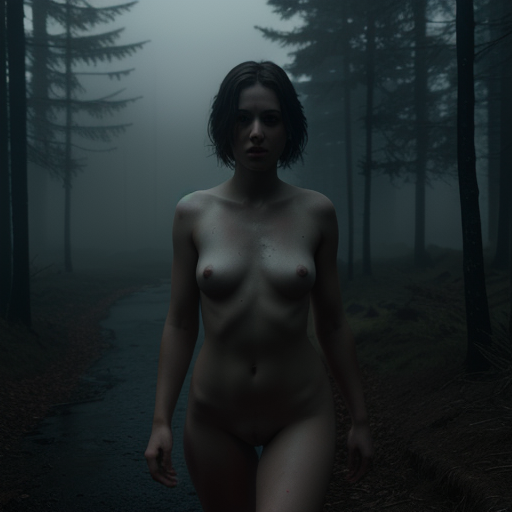

In [ ]:
# @title Работа Stable Diffusion { vertical-output: true, form-width: "100%", display-mode: "form" }
# Генерация картинки
# @markdown <-- Начать генерацию

print("###############")
print("Текущая модель Stable Diffusion: " + current_checkpoint)
print("Промпт: " + prompt)
print("Негативный промпт: " + negs)
print("Разрешение: " + str(width) + "x" + str(height))

if not randomness:
  generator = torch.Generator(current_device).manual_seed(seed)
  print("Seed этого изображения: " + str(seed) + "\n###############")
elif randomness:
  current_seed = torch.Generator(current_device).seed()
  generator = torch.Generator(current_device).manual_seed(current_seed)
  print("Seed этого изображения: " + str(current_seed) + "\n###############")

image = pipe(prompt, height=height, width=width, num_inference_steps=steps, guidance_scale=gscale, negative_prompt=negs, generator=generator, num_images_per_prompt=2).images[0]

# Вывод и сохрарнение результата

if use_gdrive:
  file_name = prompt + " " + str(current_seed) + ".png"
  temp_path = "/tmp/image.png"
  image_pil = Image.fromarray(np.uint8(image))
  image_pil.save(temp_path, "PNG")
  new_file_name = "/content/gdrive/MyDrive/SDOutput/" + file_name
  !cp $temp_path /content/gdrive/MyDrive/SDOutput
  os.rename("/content/gdrive/MyDrive/SDOutput/image.png", new_file_name)
  print("Сохранено: /content/gdrive/MyDrive/SDOutput/" + file_name)

image
# make_image_grid([init_image, image], rows=1, cols=2) # вывод сетки